In [1]:
# import libraries
import os, zipfile
import numpy as np
import pandas as pd
import nltk
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

!pip install transformers
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

from transformers import RobertaConfig, TFRobertaModel, RobertaTokenizerFast

from sklearn.model_selection import train_test_split

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 59 kB 7.4 MB/s 
     |████████████████████████████████| 3.3 MB 34.9 MB/s 
     |████████████████████████████████| 596 kB 45.0 MB/s 
     |████████████████████████████████| 895 kB 46.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
#data = pd.read_pickle('data/data')
url = 'https://raw.githubusercontent.com/ziwei-z/w266-project/main/data/en-annotated.tsv'
data = pd.read_csv(url, sep='\t', header=None, names=['sentence', 'label_raw'])
data['label_raw'] = data['label_raw'].str.split(',')
data['label'] = pd.to_numeric(data.label_raw.str[0])-1

train_X, test_X, train_Y, test_Y = train_test_split(data['sentence'], data['label'], test_size = 0.33, random_state=13)
train_X, dev_X, train_Y, dev_Y = train_test_split(train_X, train_Y, test_size = 0.2, random_state=13)

In [3]:
data[data.label==3][0:5]

,sentence,label_raw,label
1791,( isaac crying ) - it's cranky time .,[4],3
1793,( laughter ) woman :,[4],3
1794,* don't want to be re-re-re-repossessed * * re...,[4],3
1795,* Uh-oh uh-oh ... Why did you take down the [L...,"[4, 7]",3
1796,A bomb ?,[4],3


In [4]:
print(dev_X.astype(str).str.len().max())


222


In [5]:
model_name = 'roberta-base'

# Max length of tokens
max_length = 100

# Load transformers config
config = RobertaConfig.from_pretrained(model_name)

# Load BERT tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base", config = config)
config.output_hidden_states = False

# Load the Transformers BERT model
transformer_model = TFRobertaModel.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [6]:
# look at the configuration
config

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [7]:
# Load the MainLayer
roberta = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = input_ids

# Load the Transformers BERT model as a layer in a Keras model
roberta_model = roberta(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)

# Then build your model output
outputs = Dense(units=len(train_Y.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range))(pooled_output)

# And combine it all in a model object
model = Model(inputs=input_ids, outputs=outputs, name='RoBERTa_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

Model: "RoBERTa_MultiLabel_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 100)]             0         
                                                                 
 roberta (TFRobertaMainLayer  TFBaseModelOutputWithPoo  124645632
 )                           lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             100, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                     

In [ ]:
# Set an optimizer
optimizer = Adam(
    learning_rate=1e-05,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('accuracy')

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Tokenize the input (takes some time)
def tokenize(data):
    return tokenizer(
          text=data.tolist(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding='max_length', 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

x = tokenize(train_X)
x_dev = tokenize(dev_X)


# early stopping 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, min_delta=0)

# Fit the model
history = model.fit(
    x=x['input_ids'],
    y=to_categorical(train_Y),
    #validation_split = 0.2,
    validation_data=(x_dev['input_ids'], to_categorical(dev_Y)),
    batch_size=64,
    epochs=50,
    callbacks=[callback])

Epoch 1/50
 20/147 [===>..........................] - ETA: 2:16:14 - loss: 2.0595 - accuracy: 0.1789

In [ ]:
#save model
path = "/content/drive/MyDrive/W266 Project/saved models"
model.save(path+'/bert1')

#pickle.dump(model, open(path + 'bert1', 'wb'))
#loaded_model = pickle.load(open('bert_1', 'rb'))

INFO:tensorflow:Assets written to: /content/drive/MyDrive/W266 Project/saved models/bert1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/W266 Project/saved models/bert1/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


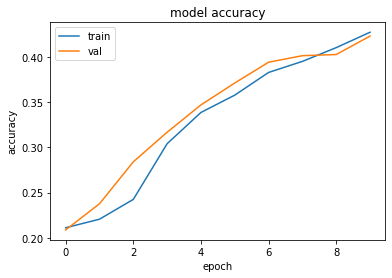

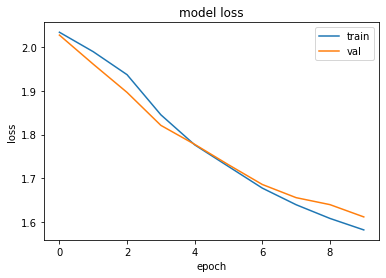

In [ ]:
#graph 


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
#evaluate

x_test = tokenize(test_X)

# Run evaluation
model_eval = model.evaluate(
    x=x_test['input_ids'],
    y=to_categorical(test_Y)
)

181/181 [==============================] - 68s 378ms/step - loss: 1.4611 - accuracy: 0.4754


In [ ]:
y_pred=model.predict(x_test['input_ids'])

In [ ]:
np.argmax(y_pred,axis=1)
con_mat = tf.math.confusion_matrix(labels=test_Y, predictions=np.argmax(y_pred, axis=1)).numpy()

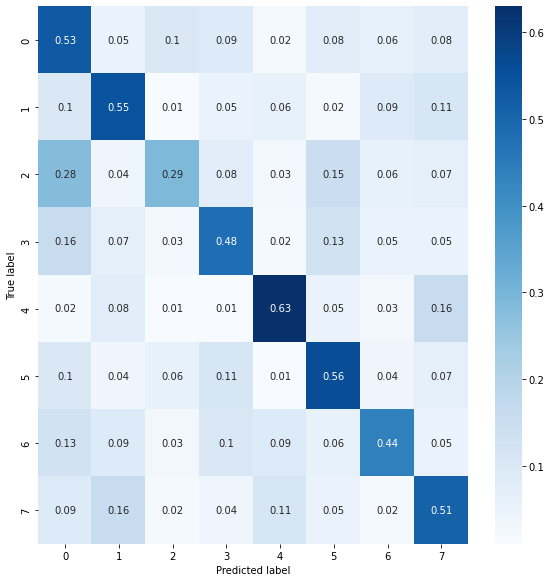

In [ ]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
classes = list(range(8))
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
list(range())

[0, 1, 2, 3, 4, 5, 6, 7, 8]